# Cahn-Hilliard with Primitive and Legendre Bases

This example uses a Cahn-Hilliard model to compare two different bases representations to discretize the microstructure. One basis representation uses the primitive (or hat) basis and the other uses Legendre polynomials. The example includes the background theory about using Legendre polynomials as a basis in MKS. The MKS with two different bases are compared with the standard spectral solution for the Cahn-Hilliard solution at both the calibration domain size and a scaled domain size. 

### Cahn-Hilliard Equation

The Cahn-Hilliard equation is used to simulate microstructure evolution during spinodial decomposition and has the following form,

$$ \dot{\phi} = \nabla^2 \left( \phi^3 - \phi \right) - \gamma \nabla^4 \phi $$

where $\phi$ is a conserved ordered parameter and $\sqrt{\gamma}$ represents the width of the interface. In this example, the Cahn-Hilliard equation is solved using a semi-implicit spectral scheme with periodic boundary conditions, see  [Chang and Rutenberg](http://dx.doi.org/10.1103/PhysRevE.72.055701) for more details.

### Basis Functions for the Microstructure Function and Influence Function

In this example, we will explore the differences when using the
Legendre polynomials as the basis function compared to the primitive
(or hat) basis for the microstructure function and the influence coefficients.

For more information about both of these basis please see the [theory section](../../THEORY.html).

In [1]:
#PYTEST_VALIDATE_IGNORE_OUTPUT

%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
from distributed import Client
import dask.array as da
from dask_ml.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

from pymks import (
    solve_cahn_hilliard,
    plot_microstructures,
    PrimitiveTransformer,
    LegendreTransformer,
    LocalizationRegressor,
    ReshapeTransformer,
    coeff_to_real
)


Client()

Client Scheduler: tcp://127.0.0.1:42867 Dashboard: http://127.0.0.1:43765/status,Cluster Workers: 4 Cores: 12 Memory: 67.15 GB


## Generating Calibration Datasets

The function `solve_cahn_hilliard` provides an interface to generate calibration datasets to model the Cahn-Hilliard system.

In [2]:
da.random.seed(99)

x_data = (2 * da.random.random((100, 41, 41), chunks=(20, 41, 41)) - 1).persist()

y_data = solve_cahn_hilliard(x_data, delta_t=1e-2).persist()

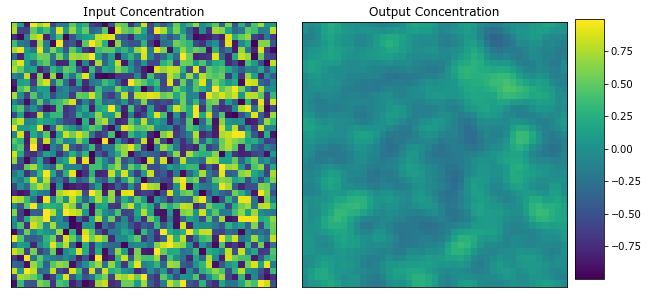

In [3]:
plot_microstructures(x_data[0], y_data[0], titles=("Input Concentration", "Output Concentration"))

## Calibrate Influence Coefficients
 
This example compares using the primitive (or hat) basis and the Legendre polynomial basis to represent the microstructure function. As mentioned above, the microstructures (concentration fields) are not discrete phases. This leaves the number of local states in local state space as a free hyperparameter.
 
## Optimizing the Number of Local States

The following compares the primitive and Legendre basis as well as `n_state`.

The sample data is split into training and test data. The code then optimizes `n_state` between `2` and `11` and the two `basis` with the `parameters_to_tune` variable. The `GridSearchCV` takes a localization pipeline and the `parameters_to_tune` and then finds the optimal parameters with a grid search.

In [4]:
x_train, x_test, y_train, y_test = train_test_split(
    x_data.reshape(x_data.shape[0], -1),
    y_data.reshape(y_data.shape[0], -1),
    test_size=0.2,
    random_state=3
)

model = Pipeline(steps=[
    ('reshape', ReshapeTransformer(shape=x_data.shape)),
    ('discretize', PrimitiveTransformer(n_state=2, min_=-1.0, max_=1.0)),
    ('regressor', LocalizationRegressor())
])    

n_states = range(2, 11)
params = dict(
    discretize__n_state=n_states,
    discretize=[PrimitiveTransformer(n_state=2, min_=-1.0, max_=1.0),
                LegendreTransformer(n_state=2, min_=-1.0, max_=1.0)]
)

grid_search = GridSearchCV(model, params, cv=5, n_jobs=-1)

grid_search.fit(x_train, y_train);

The optimal parameters are the `LegendreBasis` with only 4 local states. More terms don't improve the R-squared value.

In [5]:
#PYTEST_VALIDATE_IGNORE_OUTPUT

print(grid_search.best_estimator_)

Pipeline(memory=None,
         steps=[('reshape', ReshapeTransformer(shape=(100, 41, 41))),
                ('discretize',
                 LegendreTransformer(chunks=None, max_=1.0, min_=-1.0,
                                     n_state=4)),
                ('regressor',
                 LocalizationRegressor(redundancy_func=<function LocalizationRegressor.<lambda> at 0x7f5340660dd0>))],
         verbose=False)


In [6]:
assert np.allclose(grid_search.score(x_test, y_test), 1.0)

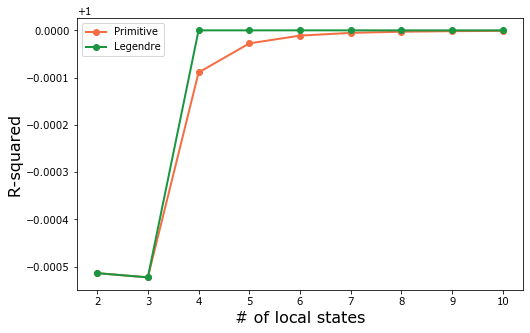

In [7]:
fig, _ = plt.subplots(1, 1, figsize=(8, 5))
plt.plot(n_states, grid_search.cv_results_['mean_test_score'][:9], 'o-', color='#f46d43', linewidth=2, label='Primitive')
plt.plot(n_states, grid_search.cv_results_['mean_test_score'][9:], 'o-', color='#1a9641', linewidth=2, label='Legendre')
plt.xlabel('# of local states', fontsize=16)
plt.ylabel('R-squared', fontsize=16)
plt.legend()
plt.show()

The `LegendreBasis` converges faster than the `PrimitiveBasis`. In order to further compare performance between the two models, select 4 local states for both bases.

## Comparing the Bases for `n_states=4`

In [27]:
model_primitive = Pipeline(steps=[
    ('reshape', ReshapeTransformer(shape=x_data.shape)),
    ('discretize', PrimitiveTransformer(n_state=4, min_=-1.0, max_=1.0)),
    ('regressor', LocalizationRegressor())
])  

tmp = model_primitive.fit(x_train, y_train).steps[2][1].coeff
primitive_coeff = coeff_to_real(tmp).real

In [28]:
model_legendre = Pipeline(steps=[
    ('reshape', ReshapeTransformer(shape=x_data.shape)),
    ('discretize', LegendreTransformer(n_state=4, min_=-1.0, max_=1.0)),
    ('regressor', LocalizationRegressor())
])  

tmp = model_legendre.fit(x_train, y_train).steps[2][1].coeff
legendre_coeff = coeff_to_real(tmp).real

Plot the primitve coefficients

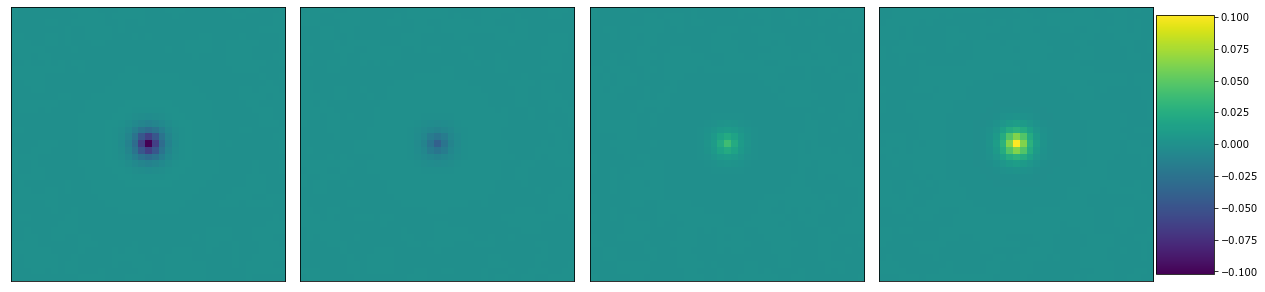

In [29]:
plot_microstructures(*(primitive_coeff[:, :, i] for i in range(4)))

Plot the Legendre coefficients

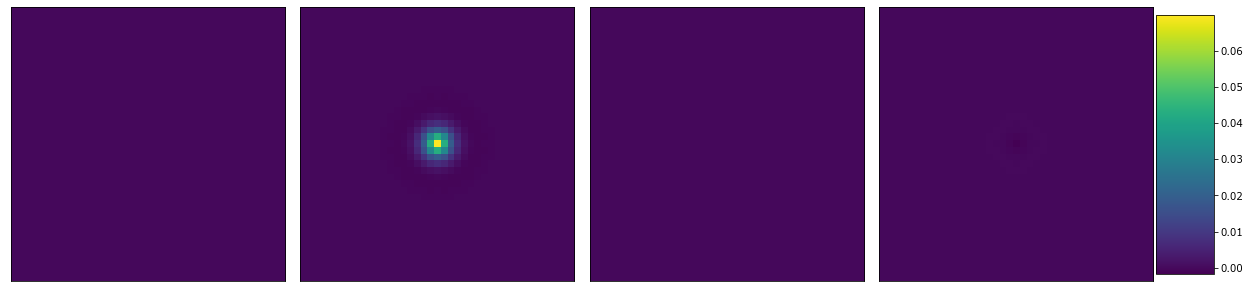

In [30]:
plot_microstructures(*(legendre_coeff[:, :, i] for i in range(4)))

## Predict Microstructure Evolution

Compare the two bases with the same data. First generate a single sample to test

In [31]:
da.random.seed(101)

x_test1 = (2 * da.random.random((1, 41, 41), chunks=(1, 41, 41)) - 1).persist()
y_test1 = solve_cahn_hilliard(x_test1, delta_t=1e-2, n_steps=10).persist()

In [32]:
y_legendre = x_test1
y_primitive = x_test1

for _ in range(10):
    y_legendre = model_legendre.predict(y_legendre).persist()
    y_primitive = model_primitive.predict(y_primitive).persist()
    
y_legendre = y_legendre.reshape(y_test1.shape).persist()
y_primitive = y_primitive.reshape(y_test1.shape).persist()

View the concentration fields

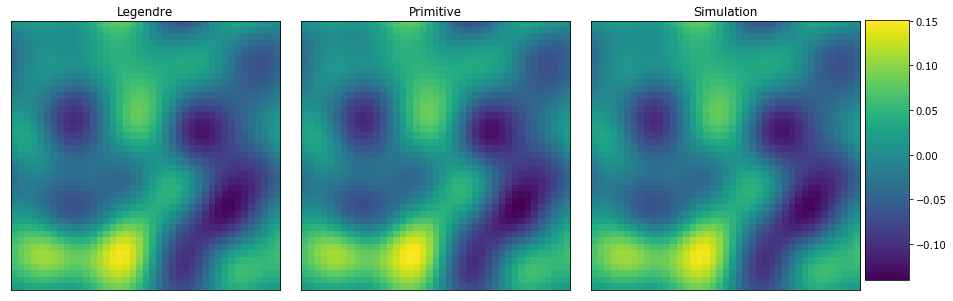

In [33]:
plot_microstructures(
    y_legendre[0],
    y_primitive[0],
    y_test1[0],
    titles=('Legendre', 'Primitive', 'Simulation')
)

By just looking at the three microstructures is it difficult to see any differences. Below plot the differences between the simulation and the models.

Primative mse = 2.0431507211056683e-06
Legendre mse = 7.181009383550321e-31


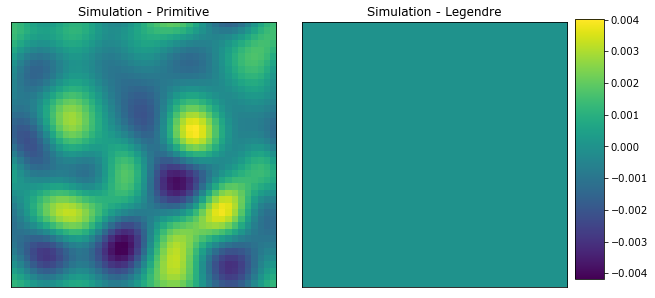

In [46]:
#PYTEST_VALIDATE_IGNORE_OUTPUT

plot_microstructures(
    y_test1[0] - y_primitive[0],
    y_test1[0] - y_legendre[0],
    titles=['Simulation - Primitive', 'Simulation - Legendre']
)

print('Primative mse =', mean_squared_error(y_test1[0], y_primitive[0]))
print('Legendre mse =', mean_squared_error(y_test1[0], y_legendre[0]))


The `LegendreBasis` basis clearly outperforms the `PrimitiveBasis` for the same value of `n_states`.

## Resizing the Coefficients to use on Larger Systems 

Compare the bases after the coefficients are resized. Generate test data that is 3x larger

In [35]:
da.random.seed(999)

size = x_data.shape[1] * 3
x_large = (2 * da.random.random((1, size, size), chunks=(1, size, size)) - 1).persist()
y_large = solve_cahn_hilliard(x_large, delta_t=1e-2, n_steps=10).persist()

In [39]:
model_primitive.steps[0][1].shape = x_large.shape
model_primitive.steps[2][1].coeff_resize(x_large.shape[1:]);

model_legendre.steps[0][1].shape = x_large.shape
model_legendre.steps[2][1].coeff_resize(x_large.shape[1:]);

View the initial and final concentration fields.

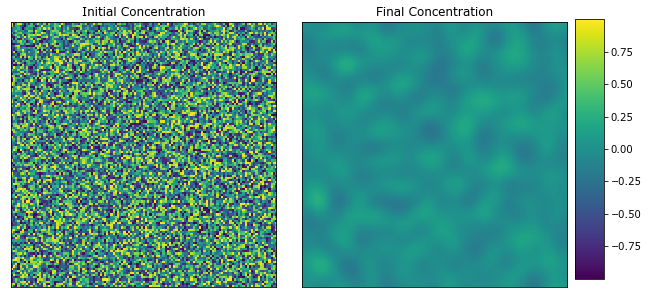

In [40]:
plot_microstructures(x_large[0], y_large[0], titles=['Initial Concentration', 'Final Concentration'])

In [41]:
y_legendre_large = x_large
y_primitive_large = x_large

for _ in range(10):
    y_legendre_large = model_legendre.predict(y_legendre_large).persist()
    y_primitive_large = model_primitive.predict(y_primitive_large).persist()
    
y_legendre_large = y_legendre_large.reshape(y_large.shape).persist()
y_primitive_large = y_primitive_large.reshape(y_large.shape).persist()

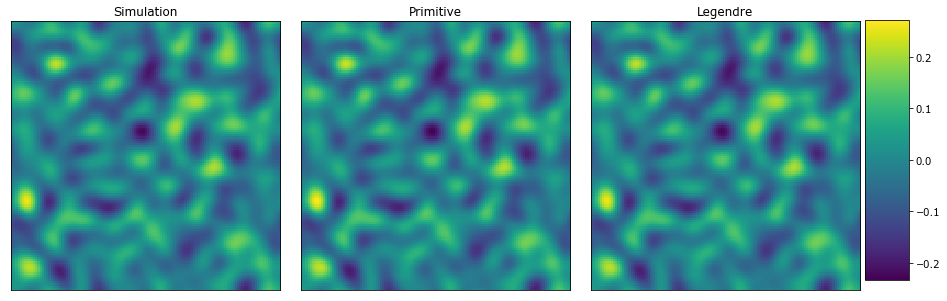

In [43]:
plot_microstructures(
    y_large[0],
    y_primitive_large[0],
    y_legendre_large[0],
    titles=('Simulation', 'Primitive', 'Legendre')
)

Both MKS models seem to predict the concentration faily well. However, the Legendre polynomial basis looks to be better. Again, let's look at the difference between the simulation and the MKS models.

Primative mse = 4.061596067141055e-06
Legendre mse = 8.829185012235967e-13


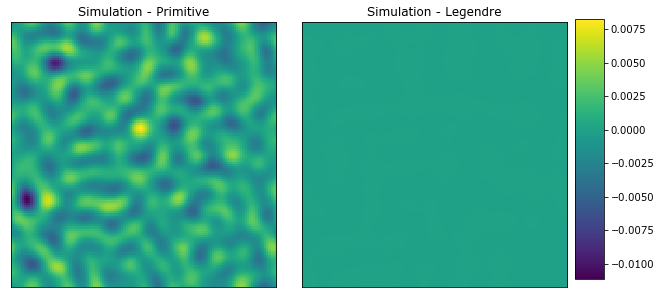

In [45]:
#PYTEST_VALIDATE_IGNORE_OUTPUT

plot_microstructures(
    y_large[0] - y_primitive_large[0],
    y_large[0] - y_legendre_large[0], 
    titles=['Simulation - Primitive','Simulation - Legendre'])

print('Primative mse =', mean_squared_error(y_large[0], y_primitive_large[0]))
print('Legendre mse =', mean_squared_error(y_large[0], y_legendre_large[0]))


With the resized influence coefficients, the `LegendreBasis` outperforms the `PrimitiveBasis` for the same value of `n_states`. However, simply comparing the calculations based only on `n_states` ignores other factors
such as number of floating point calculations and memory used.